# CMB-S4: low+high $_{\ell}$ BB ILC 

## loading necessary pthon modules

In [1]:
%load_ext autoreload
%autoreload 2

#%pylab notebook
%matplotlib inline
from pylab import *
from matplotlib import rc;rc('text', usetex=True);
import os

import argparse, sys, numpy as np, scipy as sc, warnings, os
sys.path.append('modules/')
import flatsky, misc, exp_specs
import ilc, foregrounds as fg

#import matplotlib.cbook
warnings.filterwarnings('ignore',category=RuntimeWarning)
#warnings.filterwarnings('ignore', category=DeprecationWarning)
#warnings.filterwarnings('ignore', category=matplotlib.cbook.mplDeprecation)

In [2]:
rcParams['figure.dpi'] = 125
rcParams['font.family'] = 'serif'
rcParams["figure.facecolor"] = 'white'

## load parameter file

In [3]:
#params
paramfile = 'params.ini'

# read and store param dict
param_dict = misc.fn_get_param_dict(paramfile)
el = np.arange(param_dict['lmax'])
include_gal = param_dict['include_gal']
remove_atm = param_dict['remove_atm']

## get experimental specs

In [4]:
#S4 specs
expname = 's4wide'
#expname = 's4deepv3r025' #20201019
#expname = 's4satEE'
#expname = 's4satBB'
specs_dic, corr_noise_bands, rho, corr_noise = exp_specs.get_exp_specs(expname, remove_atm = remove_atm)
freqarr = sorted( specs_dic.keys() )
nc = len( freqarr )
freqcalib_fac = None
final_comp = 'cmb'
TParr = ['T', 'P']
which_spec_arr = ['BB']
Tcmb = 2.7

colordic = {27:'navy', 39:'royalblue', 93: 'darkgreen', 145: 'goldenrod', 225: 'red', 278: 'darkred'}
if expname.find('s4sat')>-1:
    colordic = {30:'navy', 40:'royalblue', 85: 'seagreen', 95: 'darkgreen', 145: 'gold', 155: 'goldenrod', 220: 'red', 270: 'darkred'}

## extract beam and noise values from specs_dic

In [5]:
#beam and noise arr
beamarr = []
noisearr_T, elkneearr_T, alphakneearr_T = [], [], []
noisearr_P, elkneearr_P, alphakneearr_P = [], [], []
for freq in freqarr:
    beam_arcmins, white_noise_T, elknee_T, alphaknee_T, white_noise_P, elknee_P, alphaknee_P = specs_dic[freq]
    beamarr.append(beam_arcmins)
    noisearr_T.append(white_noise_T)
    noisearr_P.append(white_noise_P)
    elkneearr_T.append(elknee_T)
    elkneearr_P.append(elknee_P)
    alphakneearr_T.append(alphaknee_T)
    alphakneearr_P.append(alphaknee_P)    

print(elkneearr_P)

[700, 700, 700, 700, 700, 700]


In [6]:
#collect beam and noise into a dic; elknee and alpha into a dic
beam_noise_dic = {}
elknee_dic = {}
for TP in TParr:
    beam_noise_dic[TP] = {}
    elknee_dic[TP] = {} 
    if TP == 'T':
        freqarr, beamarr, noisearr, elkneearr, alphakneearr = freqarr, beamarr, noisearr_T, elkneearr_T, alphakneearr_T
    elif TP == 'P':
        freqarr, beamarr, noisearr, elkneearr, alphakneearr = freqarr, beamarr, noisearr_P, elkneearr_P, alphakneearr_P

    for (freq, beam, noise, elknee, alphaknee) in zip(freqarr, beamarr, noisearr, elkneearr, alphakneearr):
        if noise is None:
            noise = 1e-10
        beam_noise_dic[TP][freq] = [beam, noise]
        elknee_dic[TP][freq] = [elknee, alphaknee]

## get noise spectra N$_{\ell}$

dict_keys([(27, 27), (27, 39), (27, 93), (27, 145), (27, 225), (27, 278), (39, 27), (39, 39), (39, 93), (39, 145), (39, 225), (39, 278), (93, 27), (93, 39), (93, 93), (93, 145), (93, 225), (93, 278), (145, 27), (145, 39), (145, 93), (145, 145), (145, 225), (145, 278), (225, 27), (225, 39), (225, 93), (225, 145), (225, 225), (225, 278), (278, 27), (278, 39), (278, 93), (278, 145), (278, 225), (278, 278)])


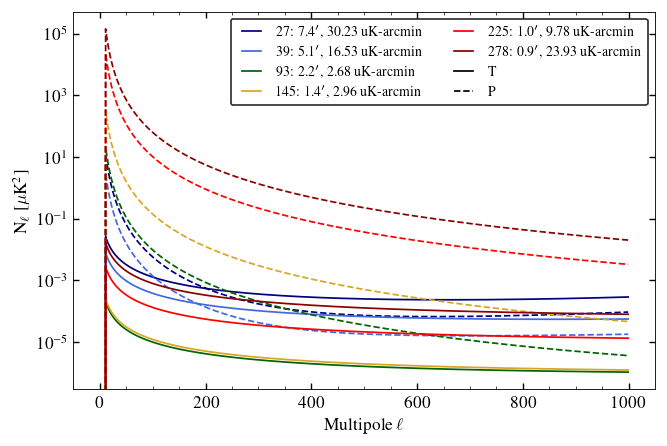

In [7]:
#get beam deconvolved noise nls
nl_dic = {}
for TP in TParr:
    nl_dic[TP]={}
    for freq1 in freqarr:
        beamval1, noiseval1 = beam_noise_dic[TP][freq1]
        elknee1, alphaknee1 = elknee_dic[TP][freq1]
        for freq2 in freqarr:        
            beamval2, noiseval2 = beam_noise_dic[TP][freq2]
            elknee2, alphaknee2 = elknee_dic[TP][freq2]
            
            if freq1 == freq2:
                nl = misc.get_nl(noiseval1, el, beamval1, elknee = elknee1, alphaknee = alphaknee1)
            else:
                if freq2 in corr_noise_bands[freq1]:
                    nl = misc.get_nl(noiseval1, el, beamval1, elknee = elknee1, alphaknee = alphaknee1, \
                                     beamval2 = beamval2, noiseval2 = noiseval2, elknee2 = elknee2, alphaknee2 = alphaknee2, rho = rho)
                else:
                    nl = np.zeros( len(el) )
            nl[el<=param_dict['lmin']] = 0.
            nl_dic[TP][(freq1, freq2)] = nl
                    
print(nl_dic['T'].keys())

if (1):#get beam deconvolved noise nls 
    ax = subplot(111, yscale = 'log')
    for freq in freqarr:
        beamval, noiseval = beam_noise_dic[TP][freq]
        if noiseval == 1e-10: continue
        for TP in TParr:
            if TP == 'P':
                labval = r'%s: %s$^{\prime}$, %.2f uK-arcmin' %(freq, beamval, noiseval)
                lsval = '-'
            else:
                labval = None
                lsval = '--'
            plot(el, nl_dic[TP][(freq, freq)], ls = lsval, label = labval, color = colordic[freq])
    plot([], [], 'k-', label = r'T')
    plot([], [], 'k--', label = r'P')
    legend(loc = 1, fontsize = 8, ncol = 2)
    xlabel(r'Multipole $\ell$'); ylabel(r'N$_{\ell}$ [$\mu$K$^{2}$]')

## get Gaussian beam B_{\ell}

dict_keys([27, 39, 93, 145, 225, 278])


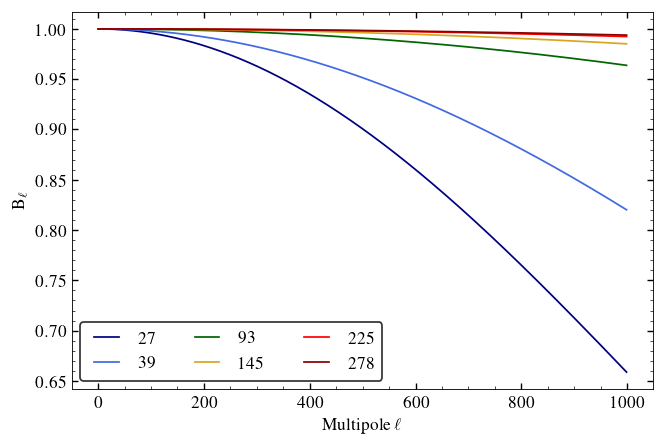

In [8]:
#get beams
bl_dic = misc.get_beam_dic(freqarr, beam_noise_dic['T'], param_dict['lmax'])
print(bl_dic.keys())
if (1):
    for freq in freqarr:
        plot(bl_dic[freq], label = freq, color = colordic[freq])
    legend(loc = 3, ncol = 3)
    xlabel(r'Multipole $\ell$'); ylabel(r'B$_{\ell}$')

## get analytic covariance for ILC

In [9]:
#get the CMB, noise, and foreground covriance
try:
    ignore_fg = param_dict['ignore_fg']
except:
    ignore_fg = []
ignore_fg.extend([final_comp.lower()]) #the required component need not go into the covariance matrix.
ignore_fg.extend(['tsz_cib'])

cl_dic = {}
fg_cl_dic = {}
for which_spec in which_spec_arr:
    if which_spec == 'TT':
        el, cl_dic[which_spec], fg_cl_dic[which_spec] = ilc.get_analytic_covariance(param_dict, freqarr, el = el, \
                nl_dic = nl_dic['T'], ignore_fg = ignore_fg, include_gal = include_gal, bl_dic = bl_dic)
    else:
        el, cl_dic[which_spec], fg_cl_dic[which_spec] = ilc.get_analytic_covariance\
                    (param_dict, freqarr, el = el, nl_dic = nl_dic['P'], ignore_fg = ignore_fg, which_spec = which_spec, \
                    pol_frac_per_cent_dust = param_dict['pol_frac_per_cent_dust'], \
                    pol_frac_per_cent_radio = param_dict['pol_frac_per_cent_radio'], \
                    pol_frac_per_cent_tsz = param_dict['pol_frac_per_cent_tsz'], \
                    pol_frac_per_cent_ksz = param_dict['pol_frac_per_cent_ksz'], \
                    include_gal = include_gal, bl_dic = bl_dic)
print(cl_dic.keys())
#print(el)

dict_keys(['BB'])


## run ILC code to get analytic residuals and band weights

In [10]:
#get the residual power now
cl_residual_arr, weights_arr = ilc.residual_power_weights(param_dict, freqarr, el, cl_dic, final_comp = final_comp, freqcalib_fac = freqcalib_fac, return_weights = 1)

In [11]:
cl_residual, weights_dic = {}, {}
for which_spec in which_spec_arr:
    if len(which_spec_arr) == 1:
       cl_res = cl_residual_arr[0]
       weights = weights_arr[:nc, 0]
    else: #fix me. add BB for joint constraints.
        if which_spec == 'TT':
           cl_res = cl_residual_arr[0]
           weights = weights_arr[nc:, 0]
        elif which_spec == 'EE':
           cl_res = cl_residual_arr[1]
           weights = weights_arr[nc:, 1]
        elif which_spec == 'TE':
           cl_res = cl_residual_arr[2]
           weights = np.asarray( [weights_arr[nc:, 0], weights_arr[:nc, 1]] )
    cl_residual[which_spec], weights_dic[which_spec] = cl_res, weights
print(cl_residual.keys())
#print(cl_residual[which_spec])
#print(weights_dic[which_spec])

dict_keys(['BB'])


## plot band weights W$_{\ell}$

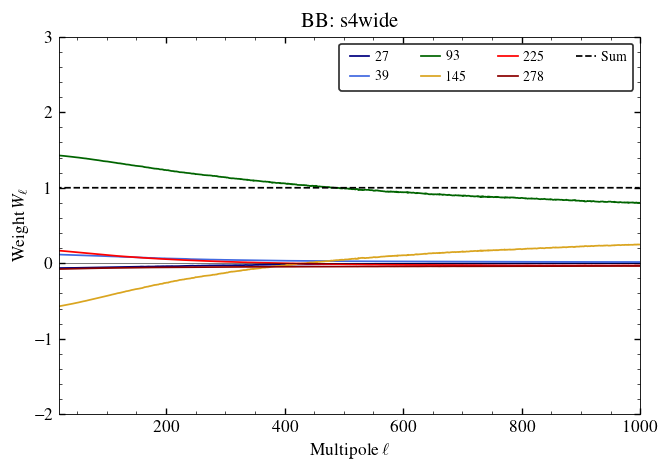

In [12]:
#plot weights
clf()
xmin, xmax = param_dict['lmin']+10, param_dict['lmax']
ymin, ymax = 1e-10,100.

for cntr, which_spec in enumerate( which_spec_arr ):
    ax = subplot(1,len(which_spec_arr),cntr+1)#, xscale = 'log')#, yscale = 'log')

    if which_spec == 'TE': continue

    for frqcntr, freq in enumerate( freqarr ):
        plot(weights_dic[which_spec][frqcntr], color = colordic[freq], label = r'%s' %(freq), lw = 1.)
    plot(np.sum(weights_dic[which_spec], axis = 0), 'k--', label = r'Sum', lw = 1.)
    axhline(lw=0.3);
    xlabel(r'Multipole $\ell$');
    #setp(ax.get_xticklabels(which = 'both'), visible=False)
    if cntr == 0:
        ylabel(r'Weight $W_{\ell}$')
        legend(loc = 1, fontsize = 8, ncol = 4, handlelength = 2., handletextpad = 0.1)
    else:
        setp(ax.get_yticklabels(which = 'both'), visible=False)
    ylim(-2., 3.);
    xlim(xmin, xmax);

    title(r'%s: %s' %(which_spec, expname))


In [13]:
fg_res_dic = {}
#signal_arr = ['tsz', 'cib', 'radio', 'galdust', 'galsync', 'noise']#, 'tsz-cib']
signal_arr = ['noise']#, 'tsz-cib']
if include_gal:
    signal_arr.extend(['galdust', 'galsync'])
for which_spec in which_spec_arr:
    fg_res_dic[which_spec] = {}
    for elcnt, currel in enumerate(el):
        if (elcnt%2500) == 0: print(which_spec, elcnt)
        for s in signal_arr:
            #print(s)
            if s == 'galdust':
                #curr_cl_dic = cl_gal_dust_dic[which_spec]
                curr_cl_dic = fg_cl_dic[which_spec]['galdust']
            elif s == 'galsync':
                #curr_cl_dic = cl_gal_sync_dic[which_spec]
                curr_cl_dic = fg_cl_dic[which_spec]['galsync']
            elif s == 'ksz':
                #curr_cl_dic = cl_ksz_dic[which_spec]
                curr_cl_dic = fg_cl_dic[which_spec]['ksz']
            elif s == 'cmb':
                #curr_cl_dic = cl_cmb_dic[which_spec]
                curr_cl_dic = fg_cl_dic[which_spec]['cmb']
            elif s == 'tsz':
                #curr_cl_dic = cl_tsz_dic[which_spec]
                curr_cl_dic = fg_cl_dic[which_spec]['tsz']
            elif s == 'cib':
                #curr_cl_dic = cl_dust_dic[which_spec]
                curr_cl_dic = fg_cl_dic[which_spec]['cib']
            elif s == 'radio':
                #curr_cl_dic = cl_radio_dic[which_spec]
                curr_cl_dic = fg_cl_dic[which_spec]['radio']
            elif s == 'tsz-cib':
                #curr_cl_dic = cl_tsz_cib_dic[which_spec]
                curr_cl_dic = fg_cl_dic[which_spec]['tsz_cib']
            elif s == 'noise':
                '''
                if which_spec == 'TT':
                    curr_cl_dic = nl_dic['T']
                elif which_spec == 'EE':
                    curr_cl_dic = nl_dic['P']
                else:
                    curr_cl_dic = None
                '''
                curr_cl_dic = fg_cl_dic[which_spec]['noise']

            ###from IPython import embed; embed()
            #print(weights_dic)
            curr_cl_fg_dic = {}
            curr_cl_fg_dic[which_spec] = curr_cl_dic
            clmat = np.mat( ilc.create_clmat(freqarr, elcnt, curr_cl_fg_dic) )
            currw_ilc = np.mat( weights_dic[which_spec][:, elcnt] )
            
            curr_res_ilc = np.asarray(np.dot(currw_ilc, np.dot(clmat, currw_ilc.T)))[0][0]
            if elcnt %500 == 0 and which_spec == 'EE' and s == 'galdust':
                print(curr_res_ilc, elcnt)
            if s not in fg_res_dic[which_spec]:
                fg_res_dic[which_spec][s] = []
            fg_res_dic[which_spec][s].append( curr_res_ilc )
    
    for s in signal_arr:
        fg_res_dic[which_spec][s] = np.asarray(fg_res_dic[which_spec][s])
print(fg_res_dic[which_spec].keys())

BB 0
dict_keys(['noise', 'galdust', 'galsync'])


## plot ILC residuals (and compare with individual N$_{\ell}$)

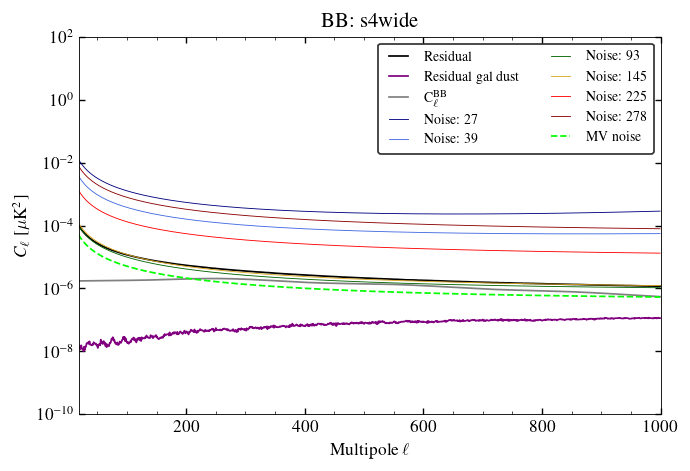

In [14]:
freq0, lmax = param_dict['freq0'], param_dict['lmax']
if include_gal:
    foregrounds_to_plot = ['kSZ', 'tSZ', 'DG-Po', 'DG-Cl', 'RG', 'galdust', 'galsync']
    pol_foregrounds_to_plot = ['galdust', 'galsync']
else:
    foregrounds_to_plot = ['kSZ', 'tSZ', 'DG-Po', 'DG-Cl', 'RG']
    pol_foregrounds_to_plot = []

#CAMB output for plotting
camb_file = '%s/%s' %(param_dict['data_folder'], param_dict['Dlfile_len'])
el_camb = np.loadtxt(camb_file, usecols = [0])
dl_camb = np.loadtxt(camb_file, usecols = [1,2,3,4])

cl_camb = ( Tcmb**2. * dl_camb * 2 * np.pi ) / ( el_camb[:,None] * (el_camb[:,None] + 1) )
cl_camb *= 1e12
cl_TT, cl_EE, cl_BB, cl_TE = cl_camb.T
cl_cmb_dic = {'TT': cl_TT, 'EE': cl_EE, 'BB': cl_BB, 'TE': cl_TE}

clf(); 
xmin, xmax = param_dict['lmin']+10, param_dict['lmax']
ymin, ymax = 1e-10,100.

for cntr, which_spec in enumerate( which_spec_arr ):
    ax = subplot(1, len(which_spec_arr), cntr+1, yscale = 'log')#, xscale = 'log')
    plot(el, cl_residual[which_spec], 'black', lw = 1., label = r'Residual')
    if include_gal: #show gal residuals here as well
        plot(el, fg_res_dic[which_spec]['galdust'], 'purple', lw = 1., label = r'Residual gal dust')

    plot(el_camb, cl_cmb_dic[which_spec], 'gray', ls = '-', lw = 1., label = r'C$_{\ell}^{\rm %s}$' %(which_spec))        
    if which_spec == 'TE':
        plot(el_camb, abs( cl_cmb_dic['TE'] ), 'gray', ls = '--', lw = 0.5) 

    if (1): #show MV nl for reference.
        mv_comb_arr = []
        for freq in freqarr:
            if which_spec == 'TT':
                nl = nl_dic['T'][(freq, freq)]
            elif which_spec == 'EE' or which_spec == 'BB':
                nl = nl_dic['P'][(freq, freq)]
            elif which_spec == 'TE':
                nl = nl_dic['T'][(freq, freq)] * 0.
            plot(el, nl, color = colordic[freq], lw = 0.5, ls = '-', label = r'Noise: %s' %(freq))#, alpha = 0.5)
            mv_comb_arr.append(1./nl)
        mv_comb = 1./(np.sum(mv_comb_arr, axis = 0))
        plot(el, mv_comb, 'lime', ls = '--', lw = 1., label = r'MV noise')
        

    xlim(xmin, xmax);
    ylim(ymin, ymax);
    xlabel(r'Multipole $\ell$')
    if cntr == 0: 
        ylabel(r'$C_{\ell}$ [$\mu$K$^{2}$]')
        legend(loc = 1, fontsize = 8, ncol = 2)
    else:
        setp(ax.get_yticklabels(which = 'both'), visible=False)
    
    title(r'%s: %s' %(which_spec, expname))